# Sentiment Analysis

> Is the American Public Willing to Change Course with President Trump?
- toc: true
- branch: master
- badges: false
- comments: true
- hide: false
- search_exclude: true
- metadata_key1: metadata_value1
- metadata_key2: metadata_value2
- image: images/sa_fig1.png
- categories: [API,NLP,   Python,nltk, R]
- show_tags: true

# PURPOSE
The purpose of this project is to demonstrate how social media data can be used to capture public sentiment.

# SUMMARY

President Trump recently authorized a missile strike on Syria in response to an alleged chemical weapon attack by the president of Syria on members of his own population on April 4 2017. This led to the beginning of heated debates about the appropriateness and consequences of this drastic, largely unexpected, and seemingly impulsive act. The presidential election afforded Trump a popular vote of 46%. One might argue that the country’s approval of the missile strike might roughly align with this partition given the recentness of the election. This investigation is about whether this is a valid assumption. My prediction is that the missile strike approval partition will be *different* from the popular vote partition. This is an interesting question for the American public as this incident of military action represents a dramatic change in direction relative to the president’s campaign stance in this regard.

The *Twitter Streaming API* was used to collect 5,000 tweets on April 11 2017, 4 days after the missile strike. It was important to collect this information as soon as possible after the event. Only tweets that contain *all* of the words 'trump syria strike' were collected (the word order did not matter). So-called *retweets* were also collected, as these were taken to indicate that the person sending the retweet agrees with the originator of the tweet. *Sentiment analysis* techniques were used. Features were extracted from the tweets in the form of words that convey *positive* sentiment (interpreted as *approval* for the strike) or *negative* sentiment (interpreted as *disapproval*). A *classifier* was then trained (using a different *labeled* data set of 100,000 tweets) to associate patterns of words with the appropriate sentiment. After training, the classifier was used to estimate the sentiment of each of the 5,000 collected tweets on the Syria missile strike. The accuracy of the classifier was found to be 75% (which means it got 75% of classifications correct on the test data).

The analysis found that, out of the 4,999 usable tweets that were collected, 2,918 were estimated to have *positive* sentiment. These were interpreted as conveying *approval* for the Syria missile strike. This number represents a 58% approval rating. Compare this with the 46% popularity rating during the presidential election (see the blue columns in Figure 1). Using a statistical proportion test, the assumption that the strike approval rating would align with the popular vote partition, was *rejected*. Strong evidence was found, therefore, that there is a clear willingness on the part of the American public to support a dramatic change of course undertaken by the president relative to his campaign stance on matters of this sort.

![](../images/sa_fig1.png "Figure 1 President Trump's Syria Strike Approval")

# CODE

# Part 1. Capture training data and train a sentiment classifier

## IMPORTANT NOTE:

Please note that the code of a few cells have been commented out. This was done to prevent accidental triggering of longer-running pieces of code (e.g. it takes about 10 minutes to train the classifier). If desired, it is easy to remove the comments to verify this code.

A Naive Bayes classifier will be trained on a labeled data set. This data set will also come from a body of tweets to ensure similarity to the style of text associated with tweets (i.e. to-the-point-ness, conciseness, use of exclamation marks, emoticons, etc.). An example of such a labeled data set is http://thinknook.com/twitter-sentiment-analysis-training-corpus-dataset-2012-09-22/. I have selected the first 100,000 rows of this data set for training.

In [15]:
import nltk
import pickle
import pandas as pd

## 1.1 Read in and prepare training data 

In [46]:
# Fix a few spurious use of quotation marks
filetext = ''
with open("SentimentAnalysisDataset.csv", encoding='utf-8') as text_file:
    filetext = text_file.read()
    filetext = filetext.replace('"" Brokeback Mountain ""', 'Brokeback Mountain')
    filetext = filetext.replace('" Brokeback Mountain "', 'Brokeback Mountain')
    filetext = filetext.replace('" brokeback mountain was terrible.', 'brokeback mountain was terrible.')
with open("SentimentAnalysisDataset_fixed.csv", "w", encoding='utf-8') as out:
    out.write(filetext)
del filetext

In [47]:
# Make a dataframe and set a split point for training/testing
# Note that a positive sentiment is indicated by a '1', and a negative sentiment by a '0' in the 'Sentiment' column
df = pd.read_csv('SentimentAnalysisDataset_fixed.csv', nrows=100000)
splitpoint = 80000 #train/test: 80%/20%
df.drop('SentimentSource', axis=1, inplace=True)
df.head()

,ItemID,Sentiment,SentimentText
0,1,0,is so sad for my APL frie...
1,2,0,I missed the New Moon trail...
2,3,1,omg its already 7:30 :O
3,4,0,.. Omgaga. Im sooo im gunna CRy. I'...
4,5,0,i think mi bf is cheating on me!!! ...


In [13]:
# Define a function to word-tokenize a tweet's text
def word_tokenize(tweet):
    """Breaks a string up into words.
    This function uses the NLTK package's word_tokenize function to split a string up
    into word tokens.
    
    Parameters
    ----------
    tweet : str
        The text of a tweet.
    
    Returns
    -------
    list
        A list consisting of the words in the input tweet string.
    """
    return(nltk.word_tokenize(tweet))

## 1.2 Gather all words in a bag and form tuples of (tokenized-tweets, sentiment)

In [49]:
from tqdm import tqdm #for progress bar
all_words = []
tweet_tuples = []
for index, row in tqdm(df.iterrows()):
    tweet_words = word_tokenize(row['SentimentText'])
    tweet_words = list(map(lambda w: w.lower(), tweet_words))
    tweet_tuples.append( (tweet_words, str(row['Sentiment'])) )
    for w in tweet_words:
        all_words.append(w)
print('Number of words: ', len(all_words))

100000it [00:34, 2870.05it/s]

Number of words:  1719434


In [50]:
# Recover some memory
del df
del index
del row
del tweet_words
del w

## 1.3 Get frequency distribution of the words

The 30 most common words are:  [('@', 90794), ('i', 62578), ('!', 57937), ('.', 51116), (',', 32555), ('the', 29914), ('you', 29844), ('to', 29561), ('?', 25284), ('a', 22062), ('it', 22041), ('...', 18448), ('and', 16303), (';', 16178), ('&', 14440), ('my', 13790), ('that', 13587), ('for', 12553), ('is', 12534), ("'s", 11912), ('in', 11822), ("n't", 11791), ('me', 11025), ('of', 10606), ('have', 10531), ('on', 9618), ('quot', 9153), ('so', 9106), ('but', 8956), ("'m", 8500)]


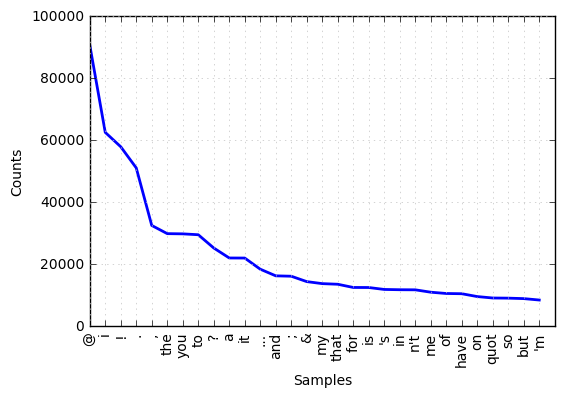

In [51]:
all_words = nltk.FreqDist(all_words)

# inspect the frequency distribution of the words
print('The 30 most common words are: ', all_words.most_common(30))
all_words.plot(30, cumulative=False)

## 1.4 Select the top 5000 most common words as features

In [53]:
freq_tuples = all_words.most_common(5000)

## 1.5 Remove the 30 most common words again
The most common words often have less 'signal' in them and may be ignored.

In [54]:
freq_tuples = freq_tuples[30:] #remove the 30 most common words

## 1.6 Prepare the word features

In [55]:
word_features = [w for (w, freq) in freq_tuples]

## 1.7 Save the word_features

In [57]:
f = open('word_features.pkl', 'wb')
pickle.dump(word_features, f)
f.close()

In [58]:
# Recover memory
del all_words
del freq_tuples

In [11]:
# Define a function to extract sentiment features from the words of a tweet.
def sentiment_features(tweet_words):
    """Extract sentiment features from a tweet.
    This function extracts sentiment features from the words of a tweet.
    
    Parameters
    ----------
    tweet_words : list of words
        The text of a tweet, tokenized into words.
    
    Returns
    -------
    dict
        A dictionary that has a key for each word in the list of word features (word_features).
        The value of each entry indicates whether that specific word is present in this tweet.
    """
    uniq_words = set(tweet_words) #keep unique words only
    features = {}
    for w in word_features:
        features[w] = (w in uniq_words)
    return(features)

## 1.8 Prepare featuresets for the complete classifier data set

In [60]:
from tqdm import tqdm
featuresets = [(sentiment_features(tweet_words), sentiment) for (tweet_words, sentiment) in tqdm(tweet_tuples)]
print('Number of featuresets: ', len(featuresets))

100%|██████████| 100000/100000 [01:29<00:00, 1119.71it/s]

Number of featuresets:  100000


In [61]:
# Recover memory
del tweet_tuples

## 1.9 Split the data set for training and testing

In [66]:
# Takes about 1 minute
training_set = featuresets[:splitpoint]
testing_set = featuresets[splitpoint:]
print('Length of featuresets: ', len(featuresets))
print('Length of training_set: ', len(training_set))
print('Length of testing_set: ', len(testing_set))

Length of featuresets:  100000
Length of training_set:  80000
Length of testing_set:  20000


In [67]:
# Recover memory
del featuresets

## 1.10 Train classifier

In [22]:
# takes about 10 minutes
"""commented out to protect
classifier = nltk.NaiveBayesClassifier.train(tqdm(training_set))
"""

100%|██████████| 80000/80000 [09:46<00:00, 136.45it/s]


## 1.11 Score classifier

In [28]:
# takes about 10 minutes
"""commented out to protect
accuracy = nltk.classify.accuracy(classifier, testing_set)
print('Accuracy: ', accuracy)
"""

Accuracy:  0.75205


In [29]:
# show_most_informative_features: 1 for positive, 0 for negative
"""commented out to protect
classifier.show_most_informative_features(40)
"""

Most Informative Features
               cancelled = True                0 : 1      =     29.0 : 1.0
                   ak618 = True                0 : 1      =     29.0 : 1.0
             appreciated = True                1 : 0      =     26.2 : 1.0
            aaroncarter7 = True                0 : 1      =     24.0 : 1.0
                 *cries* = True                0 : 1      =     24.0 : 1.0
                 hurting = True                0 : 1      =     21.4 : 1.0
                    grrr = True                0 : 1      =     21.4 : 1.0
                     sad = True                0 : 1      =     21.1 : 1.0
                canceled = True                0 : 1      =     19.8 : 1.0
             musicmonday = True                1 : 0      =     19.7 : 1.0
          recommendation = True                1 : 0      =     18.2 : 1.0
                 sadness = True                0 : 1      =     18.1 : 1.0
                  gutted = True                0 : 1      =     17.5 : 1.0

## 1.12 Define a function to estimate the sentiment of a tweet

In [9]:
# Define a function to estimate the sentiment of a tweet.
def estimate_sentiment(tweet):
    """Estimate the sentiment of a tweet.
    This function estimates the sentiment of a tweet.
    
    Parameters
    ----------
    tweet : str
        The text of a tweet.
    
    Returns
    -------
    int
        A value that indicates the sentiment of the tweet: 
        1 for positive, and
        0 for negative
    """
    return( classifier.classify(sentiment_features(word_tokenize(tweet))) )

## 1.13 Hand-test classifier

In [69]:
print( estimate_sentiment('I feel fine today!') )
print( estimate_sentiment('I feel horrible today!') )
print( estimate_sentiment('This is good news.') )
print( estimate_sentiment('This was a mistake') )
print( estimate_sentiment('He had to do it') )
print( estimate_sentiment('Not fair to Syria') )

1
0
1
0
1
0


## 1.14 Save classifier

In [32]:
"""commented out to protect
f = open('tweepy_naivebayes.pkl', 'wb')
pickle.dump(classifier, f)
f.close()
"""

# Part 2. Capture twitter data on Trump Syria Strike

In [70]:
import tweepy
import time
from datetime import datetime

In [71]:
file_name = 'trump_syria_strike15.txt'
track_string = 'trump syria strike'

In [ ]:
# Define a class to setup and capture a stream of tweets.
class WritingTxtStreamListener(tweepy.StreamListener):
    """Sets up and captures a stream of tweets.    
    This class sets up and captures a stream of tweets from the Twitter Streaming API.    
    """
    __count = 0

    #captures the json of a tweet
    def on_data(self, data):
        try:
            f = open(file_name, 'a', encoding='utf-8')
            f.write( data )
            f.close()
            self.__count += 1
            print( str(datetime.now().time())+': '+str(self.__count) )
            return(True)
        except BaseException as e:
            print('ERROR: ' + str(e))
            time.sleep(5)

    #disconnect the stream if we receive an error message indicating we are overloading Twitter
    def on_error(self, status_code):
        print('ERROR: status_code = ' + str(status_code))
        if status_code == 420:
            #returning False in on_data disconnects the stream
            return False

In [ ]:
con_key = ''
con_secret = ''
acc_token = ''
acc_secret = ''

In [ ]:
# Authenticate
auth = tweepy.OAuthHandler(consumer_key=con_key, consumer_secret=con_secret)
auth.set_access_token(acc_token, acc_secret)

In [ ]:
# Create a wrapper for the API provided by Twitter
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True, retry_count=10, retry_delay=5, retry_errors=5)         

In [ ]:
# Create and authenticate an instance of our listener class
my_stream_listener = WritingTxtStreamListener()
my_stream = tweepy.Stream(auth = api.auth, listener=my_stream_listener)

In [ ]:
# Collect tweets
my_stream.filter(track=[track_string], languages=['en'])

In [ ]:
# Disconnect from stream
my_stream.disconnect()

# 3. Analyze twitter data on Trump Syria Strike

In [1]:
import json
import pandas as pd

## 3.1 Load the json study data

In [32]:
tweets_data = []
tweets_file = open('trump_syria_strike15.txt', "r")
for line in tweets_file:
    try:
        tweet_json = json.loads(line)
        tweets_data.append(tweet_json)
    except:
        continue
tweets_file.close()
print( 'Number of tweets: ', len(tweets_data) )

Number of tweets:  5000


In [33]:
# Setup a dataframe
tweets = pd.DataFrame()
tweets['text'] = list(map(lambda x: x['text'], tweets_data))
tweets.head()

,text
0,RT @WilliamAder: Most daughters would be happy...
1,RT @TheEconomist: Listen: We discuss what Dona...
2,RT @davebernstein: Translation:\n\nIntent of S...
3,RT @JoeMyGod: Ann Coulter Denounces Trump Over...
4,RT @ddale8: Can you even imagine if a Hillary ...


In [34]:
# Remove newlines within a tweet
import re
def suppress_newlines(tweet):
    res = re.sub(r'\n', ' ', tweet)
    return(res)

tweets['text'] = tweets['text'].apply(suppress_newlines)

## 3.2 Load the sentiment classifier

In [35]:
import pickle
f = open('tweepy_naivebayes.pkl', 'rb')
classifier = pickle.load(f)
f.close()

## 3.3 Load the word features (from word_features)

In [36]:
f = open('word_features.pkl', 'rb')
word_features = pickle.load(f)
f.close()

## 3.4 Estimate the sentiment for each tweet in the data on Trump Syria Strike

In [37]:
# Takes about 3 minutes: uncomment the progress bar activation code if needed:
#from tqdm import tqdm, tqdm_pandas
#tqdm_pandas(tqdm())

tweets['est_sentiment'] = ''
#tweets['est_sentiment'] = tweets['text'].progress_apply(estimate_sentiment)
tweets['est_sentiment'] = tweets['text'].apply(estimate_sentiment)
tweets.head()

,text,est_sentiment
0,RT @WilliamAder: Most daughters would be happy...,1
1,RT @TheEconomist: Listen: We discuss what Dona...,1
2,RT @davebernstein: Translation: Intent of Syr...,0
3,RT @JoeMyGod: Ann Coulter Denounces Trump Over...,1
4,RT @ddale8: Can you even imagine if a Hillary ...,0


## 3.5 Save analysis in updated dataframe

In [38]:
tweets.to_csv('trump_syria_strike15.csv', encoding='utf-8', sep='|')

# 4. Statistical proportion test
### (R Language)

~~~ r
## Load sentiment data on Trump Syria Strike
df <- read.csv("trump_syria_strike15.csv", sep = "|", stringsAsFactors = FALSE)
head(df)
names(df)
~~~

~~~ r
## Count the tweets with positive sentiment, disregard a handful of rows that have NAs
total.evals <- sum(complete.cases(df))
total.evals
total.approvals <- sum(df[,'est_sentiment'], na.rm = TRUE)
total.approvals
fraction.approvals <- total.approvals/total.evals
fraction.approvals
~~~

~~~ r
## Perform a hypothesis test of proportions

### Setup hypotheses

The hypotheses will be:

    H0: p = p0
    H1: p != p0
    
where 

p is the true proportion of the American public that *approves* the strike, and p0 = 0.46. 
    
The *null* hypothesis, therefore, states that the proportion of the public that *approves* the strike (associated with *positive* sentiment tweets), is the *same* as the proportion of popular votes (46%) during the presidential election. 
    
The *alternative* hypothesis, states that the proportion of the public that approves the strike is *different* from the proportion of popular votes. The type of hypothesis test will be a *one-sample test for a proportion*. The test will be *two-sided*.

### Perform hypothesis test

prop.test(total.approvals, n = total.evals, p = 0.46, alternative = 'two.sided')

### Conclusion

The p-value is much smaller than 0.05. At the 0.05 significance level, we *reject* the null hypothesis. There is enough evidence to claim that the proportion of the American public that *approves* the missile strike is *different* from 46%. The proportion that approves the strike is 58%.
~~~